# Deutsch–Jozsa Algorithm

> Note: This notebook is strongly inspired by the [Qiskit tutorial on the Deutsch–Jozsa algorithm](https://learning.quantum.ibm.com/course/fundamentals-of-quantum-algorithms/quantum-query-algorithms#the-deutsch-jozsa-algorithm).*


The Deutsch–Jozsa algorithm is one of the earliest examples to demonstrate exponential quantum speedup.  
Given access to a "black box" Boolean function $f:\{0,1\}^n \to \{0,1\}$, which is promised to be either **constant** (same output for all inputs) or **balanced** (outputs 0 for half of all inputs and 1 for the other half), the goal is to determine which is the case with a single quantum query.

This notebook shows:
- Construction of query oracles for both function types,
- Execution of the Deutsch–Jozsa algorithm,
- Demonstration of the speedup over classical methods,
- (Bonus) Bernstein–Vazirani algorithm, which uses a similar structure.


## Deutsch–Jozsa Oracle Construction

The oracle implements a Boolean function $f(x): \{0,1\}^n \rightarrow \{0,1\}$,  
encoded as a quantum operation:
\begin{equation*}
U_f |x\rangle|y\rangle = |x\rangle|y \oplus f(x)\rangle
\end{equation*}

We randomly generate oracles for constant and balanced functions.


In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import numpy as np


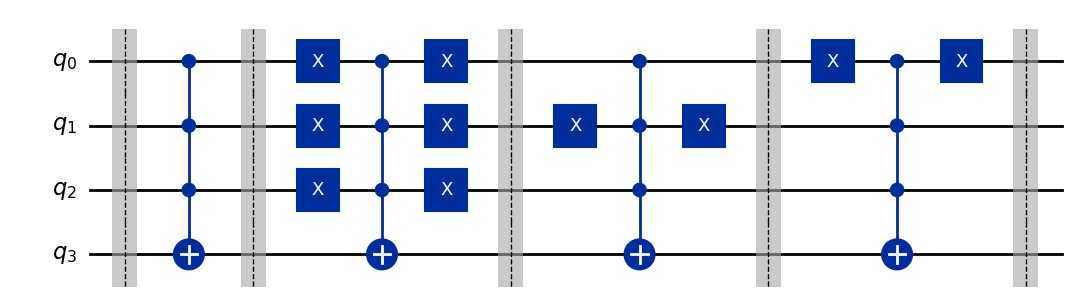

In [2]:
def dj_query(num_qubits):
    """
    Generates a Deutsch–Jozsa oracle as a QuantumCircuit.
    With 50% chance, returns a constant oracle; otherwise, returns a balanced oracle.
    """
    qc = QuantumCircuit(num_qubits + 1)

    if np.random.randint(0, 2):
        # With 50% chance, flip the output qubit, making a constant function
        qc.x(num_qubits)
    if np.random.randint(0, 2):
        # Return constant function oracle
        return qc

    # Otherwise, construct a balanced function: output 1 for half the inputs
    on_states = np.random.choice(
        range(2**num_qubits), 2**num_qubits // 2, replace=False
    )

    def add_x_gates(qc, bit_string):
        # Helper: flips qubits according to bit_string
        for qubit, bit in enumerate(reversed(bit_string)):
            if bit == "1":
                qc.x(qubit)
        return qc

    for state in on_states:
        qc.barrier()
        qc = add_x_gates(qc, f"{state:0{num_qubits}b}")
        qc.mcx(list(range(num_qubits)), num_qubits)
        qc = add_x_gates(qc, f"{state:0{num_qubits}b}")

    qc.barrier()
    return qc

# Example: visualize a random 3-bit Deutsch–Jozsa oracle
display(dj_query(3).draw(output="mpl"))


## Deutsch–Jozsa Algorithm Circuit

The Deutsch–Jozsa algorithm uses the following steps:
1. Prepare $n$ input qubits in $\ket{0}$, 1 output qubit in $\ket{1}$
2. Apply Hadamard gates to all qubits
3. Query the oracle
4. Apply Hadamard gates to the input qubits
5. Measure the input qubits


In [3]:
def compile_circuit(function: QuantumCircuit):
    """
    Assembles a quantum circuit to run the Deutsch–Jozsa algorithm
    with the provided oracle function.
    """
    n = function.num_qubits - 1
    qc = QuantumCircuit(n + 1, n)
    qc.x(n)                      # Initialize output qubit to |1>
    qc.h(range(n + 1))           # Hadamard to all
    qc.compose(function, inplace=True)
    qc.h(range(n))               # Hadamard to input qubits
    qc.measure(range(n), range(n))
    return qc


## Deutsch–Jozsa Algorithm Execution

If the measured result is all zeros (`"00...0"`), the function is **constant**.  
Otherwise (if any '1' is measured), the function is **balanced**.


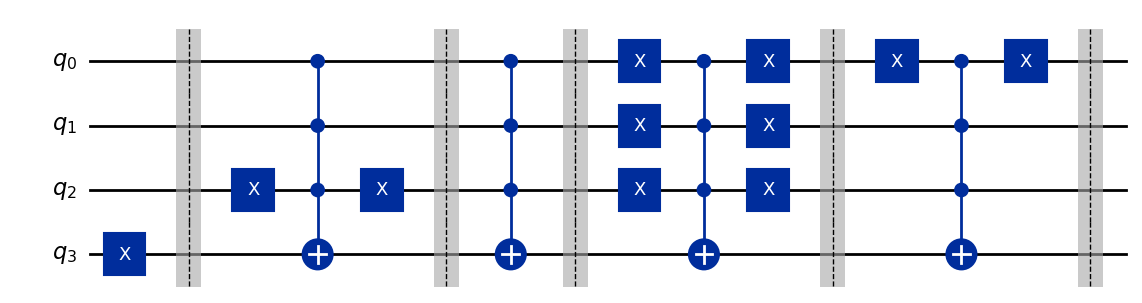

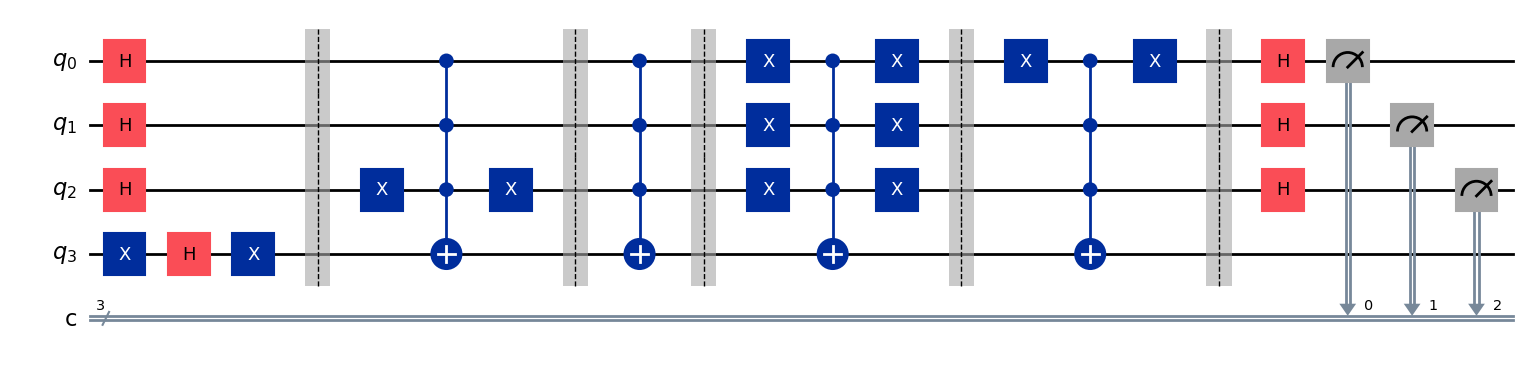

Deutsch–Jozsa result: balanced


In [4]:
def dj_algorithm(function: QuantumCircuit):
    """
    Runs the Deutsch–Jozsa algorithm.
    Returns 'constant' or 'balanced' based on the result.
    """
    qc = compile_circuit(function)
    display(qc.draw('mpl'))
    result = AerSimulator().run(transpile(qc, AerSimulator()), shots=1, memory=True).result()
    measurements = result.get_memory()
    if "1" in measurements[0]:
        return "balanced"
    return "constant"

# Example: run algorithm with a random oracle
f = dj_query(3)
display(f.draw("mpl"))
print("Deutsch–Jozsa result:", dj_algorithm(f))


## Interpretation

The Deutsch–Jozsa algorithm can distinguish constant from balanced functions with a **single query**,  
while any classical deterministic algorithm would require up to $2^{n-1} + 1$ queries.